In [1]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
from libs.datasets import MNIST
import os
from libs.utils import montage
from libs import gif
%matplotlib inline

## Data

In [2]:
rootdir = "db/notMNIST_small/"
image_names = []
labels = []
[subdirs for subdirs in os.listdir(rootdir)]
#[img for img in os.listdir(d) if img.endswith('png')]
for dirpath, dirname, files in os.walk(rootdir):
    for f in files:
        if f.endswith('.png'):
            image_names.append(os.path.join(dirpath,f))
            labels.append(dirpath.split('/')[1])
print image_names[:5], labels[:5], len(image_names)

['db/notMNIST_small/A/MDEtMDEtMDAudHRm.png', 'db/notMNIST_small/A/MDRiXzA4LnR0Zg==.png', 'db/notMNIST_small/A/MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png', 'db/notMNIST_small/A/MlJlYmVsc0RldXgtQmxhY2sub3Rm.png', 'db/notMNIST_small/A/MlRvb24gU2hhZG93LnR0Zg==.png'] ['notMNIST_small', 'notMNIST_small', 'notMNIST_small', 'notMNIST_small', 'notMNIST_small'] 18726


In [3]:
data = []
target = []
number_of_images = 10000
for i in range(1, number_of_images + 1):
    rand_int = np.random.randint(0,len(image_names))
    img_name = image_names[rand_int]
    label = labels[rand_int]
    try:
        img = plt.imread(img_name)
    except:
        continue
    data.append(img)
    target.append(label)
#     plt.subplot(number_of_images,1,i)
#     plt.imshow(img)
#     plt.ylabel(label)

data = np.array(data)

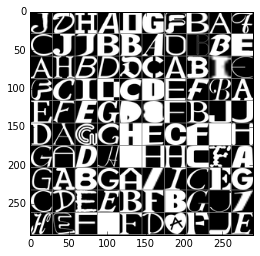

In [163]:
plt.imshow(montage(data[:100]),cmap='gray')

image size: (28, 28) data size: (9999, 28, 28)
(9999, 784) (784, 9999)


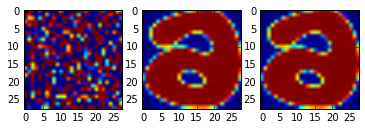

In [4]:
print "image size:", data[0].shape,"data size:", data.shape
data_ = data.reshape(-1,28*28)
new = data.reshape(28*28,-1)
print data_.shape, new.shape
f,ax = plt.subplots(1,3)
ax[0].imshow(new[:,0].reshape(28,28))
ax[1].imshow(data_[0,:].reshape(28,28))
ax[2].imshow(data[0])

(28, 28)

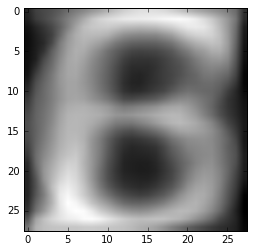

In [137]:
mean_img = np.mean(data, axis=0)
plt.imshow(mean_img,cmap='gray')
mean_img.shape

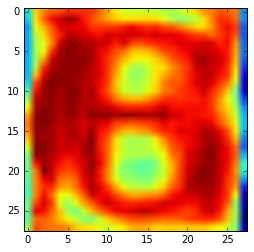

In [54]:
std_img = np.std(data,axis = 0)
plt.imshow(std_img)

## Build autoencoder network

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

dimensions = [512, 256, 128, 64]
n_features = data.shape[1]*data.shape[2]
print n_features
X = tf.placeholder(tf.float32,[None, n_features])

784


In [6]:
current_input = X
n_input = n_features
Ws = []

for layer_i, n_output in enumerate(dimensions):

    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        Ws.append(W)
        n_input = n_output


In [7]:
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:]
dimensions.append(n_features)
print(dimensions)

[128, 256, 512, 784]


In [118]:
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [121]:
Y = current_input
# We'll first measure the average difference across every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())
cost = tf.reduce_mean(cost)
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess.run(tf.global_variables_initializer())

(?,)


(10, 784)
(0, 0.16180372)
(1, 0.16104816)
(2, 0.16053329)
(3, 0.16022037)
(4, 0.15992506)


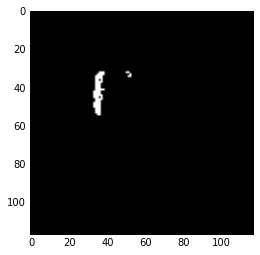

In [161]:
# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = data_[:10]
print examples.shape
mean_im = mean_img.reshape((-1,784))

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
# plt.imshow(montage(data_[:10].reshape(-1,28,28)))

for epoch_i in range(n_epochs):
#     for batch_X, _ in ds.train.next_batch():
    sess.run(optimizer, feed_dict={X: data_[10:10000]-mean_im})
    recon = sess.run(Y, feed_dict={X: examples - mean_im})
    recon = np.clip((recon + mean_im).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: data_[10:40] - mean_im}))
# gif.build_gif(imgs, saveto='ae.gif', cmap='gray')